In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
sys.path.append('..')
from helpers import *
from implementations import *
%load_ext autoreload
%autoreload 2

In [2]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

with open(DATA_TRAIN_PATH) as f:
    labels = f.readline().split(',')[2:] #remove 2 first, being ID and prediction
df=pd.read_csv(DATA_TRAIN_PATH)


## I .First steps 

Let's have a look at the shape of the data first

In [3]:
df.head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


Each of the 250000 data point is uniquely identified and labeled, and offers 30 different features, either discrete or continunous.

It seems that some colums often have invalid values (-999.0), we'll have a look later.

Let's now try looking at the empirical distribution for each of those features.

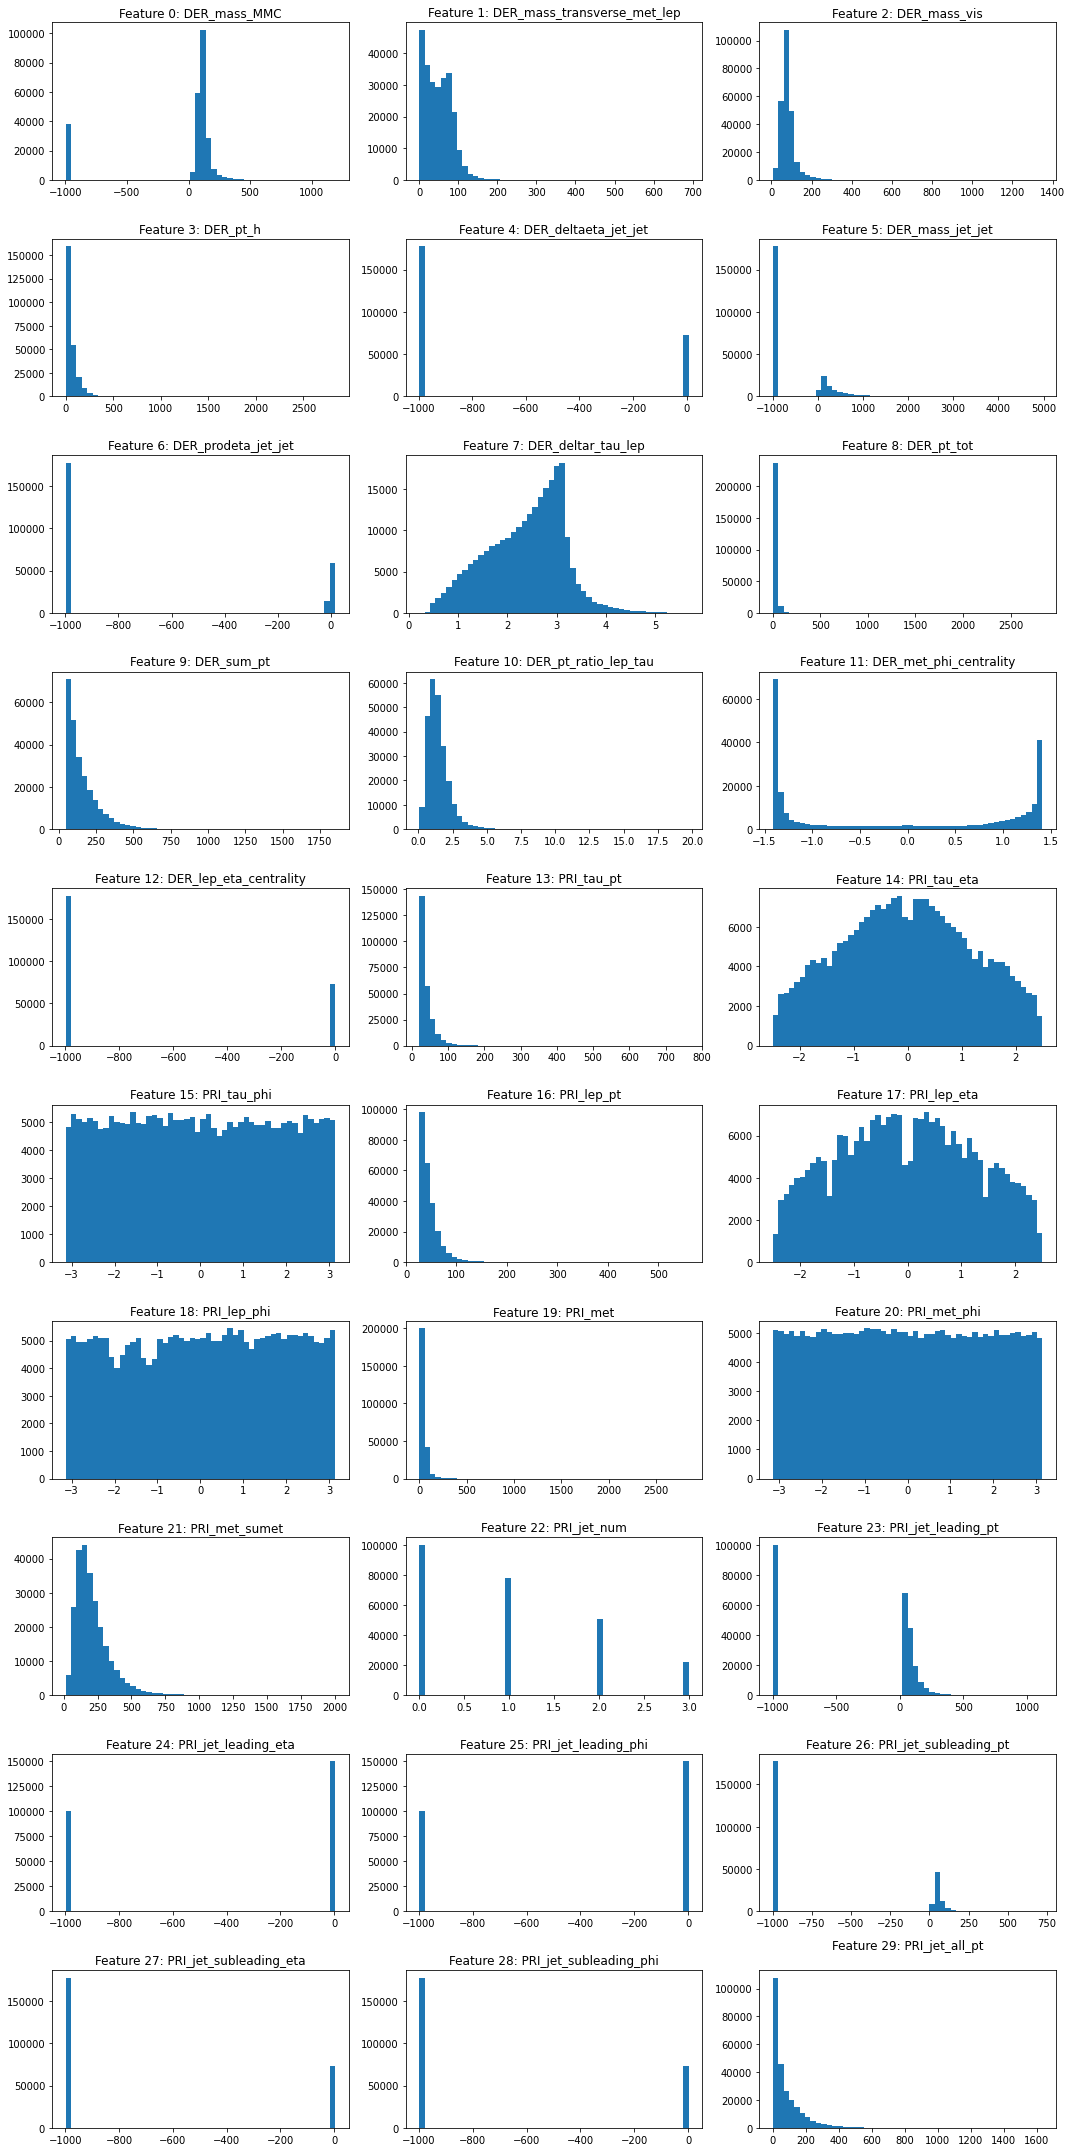

In [4]:
def plot_features_distrib(tX):
    plt.figure(figsize=(15,30))
    for i in range(tX.shape[1]):
        plt.subplot(10,3,i+1)
        plt.hist(tX[:,i], bins=50);
        plt.title("Feature {}: {}".format(i, labels[i]))
    plt.tight_layout()
    plt.show();
plot_features_distrib(tX)

We can confirm what we suggested before, some features (such as 12, 26, 27, 28), mostly contains invalid values. Instead of simply removing them, we should have a look later to see if we could possibly extract some information out of them ! 

We also see that the discrete features offer only a small amout of different values, it might be interesting on the future to plot distributions while discriminating over those discrete values! 

The continuous features offer a wide range of distributions, 15, 18 and 20 for example appear to be uniform distribution.

We should also check wether or not 21, 23, 29 are heavy tailed

Some, such as 1 or 7, are bimodal distributions, we might get some insight while discriminating over the label !

## II. Discriminating over the prediction label

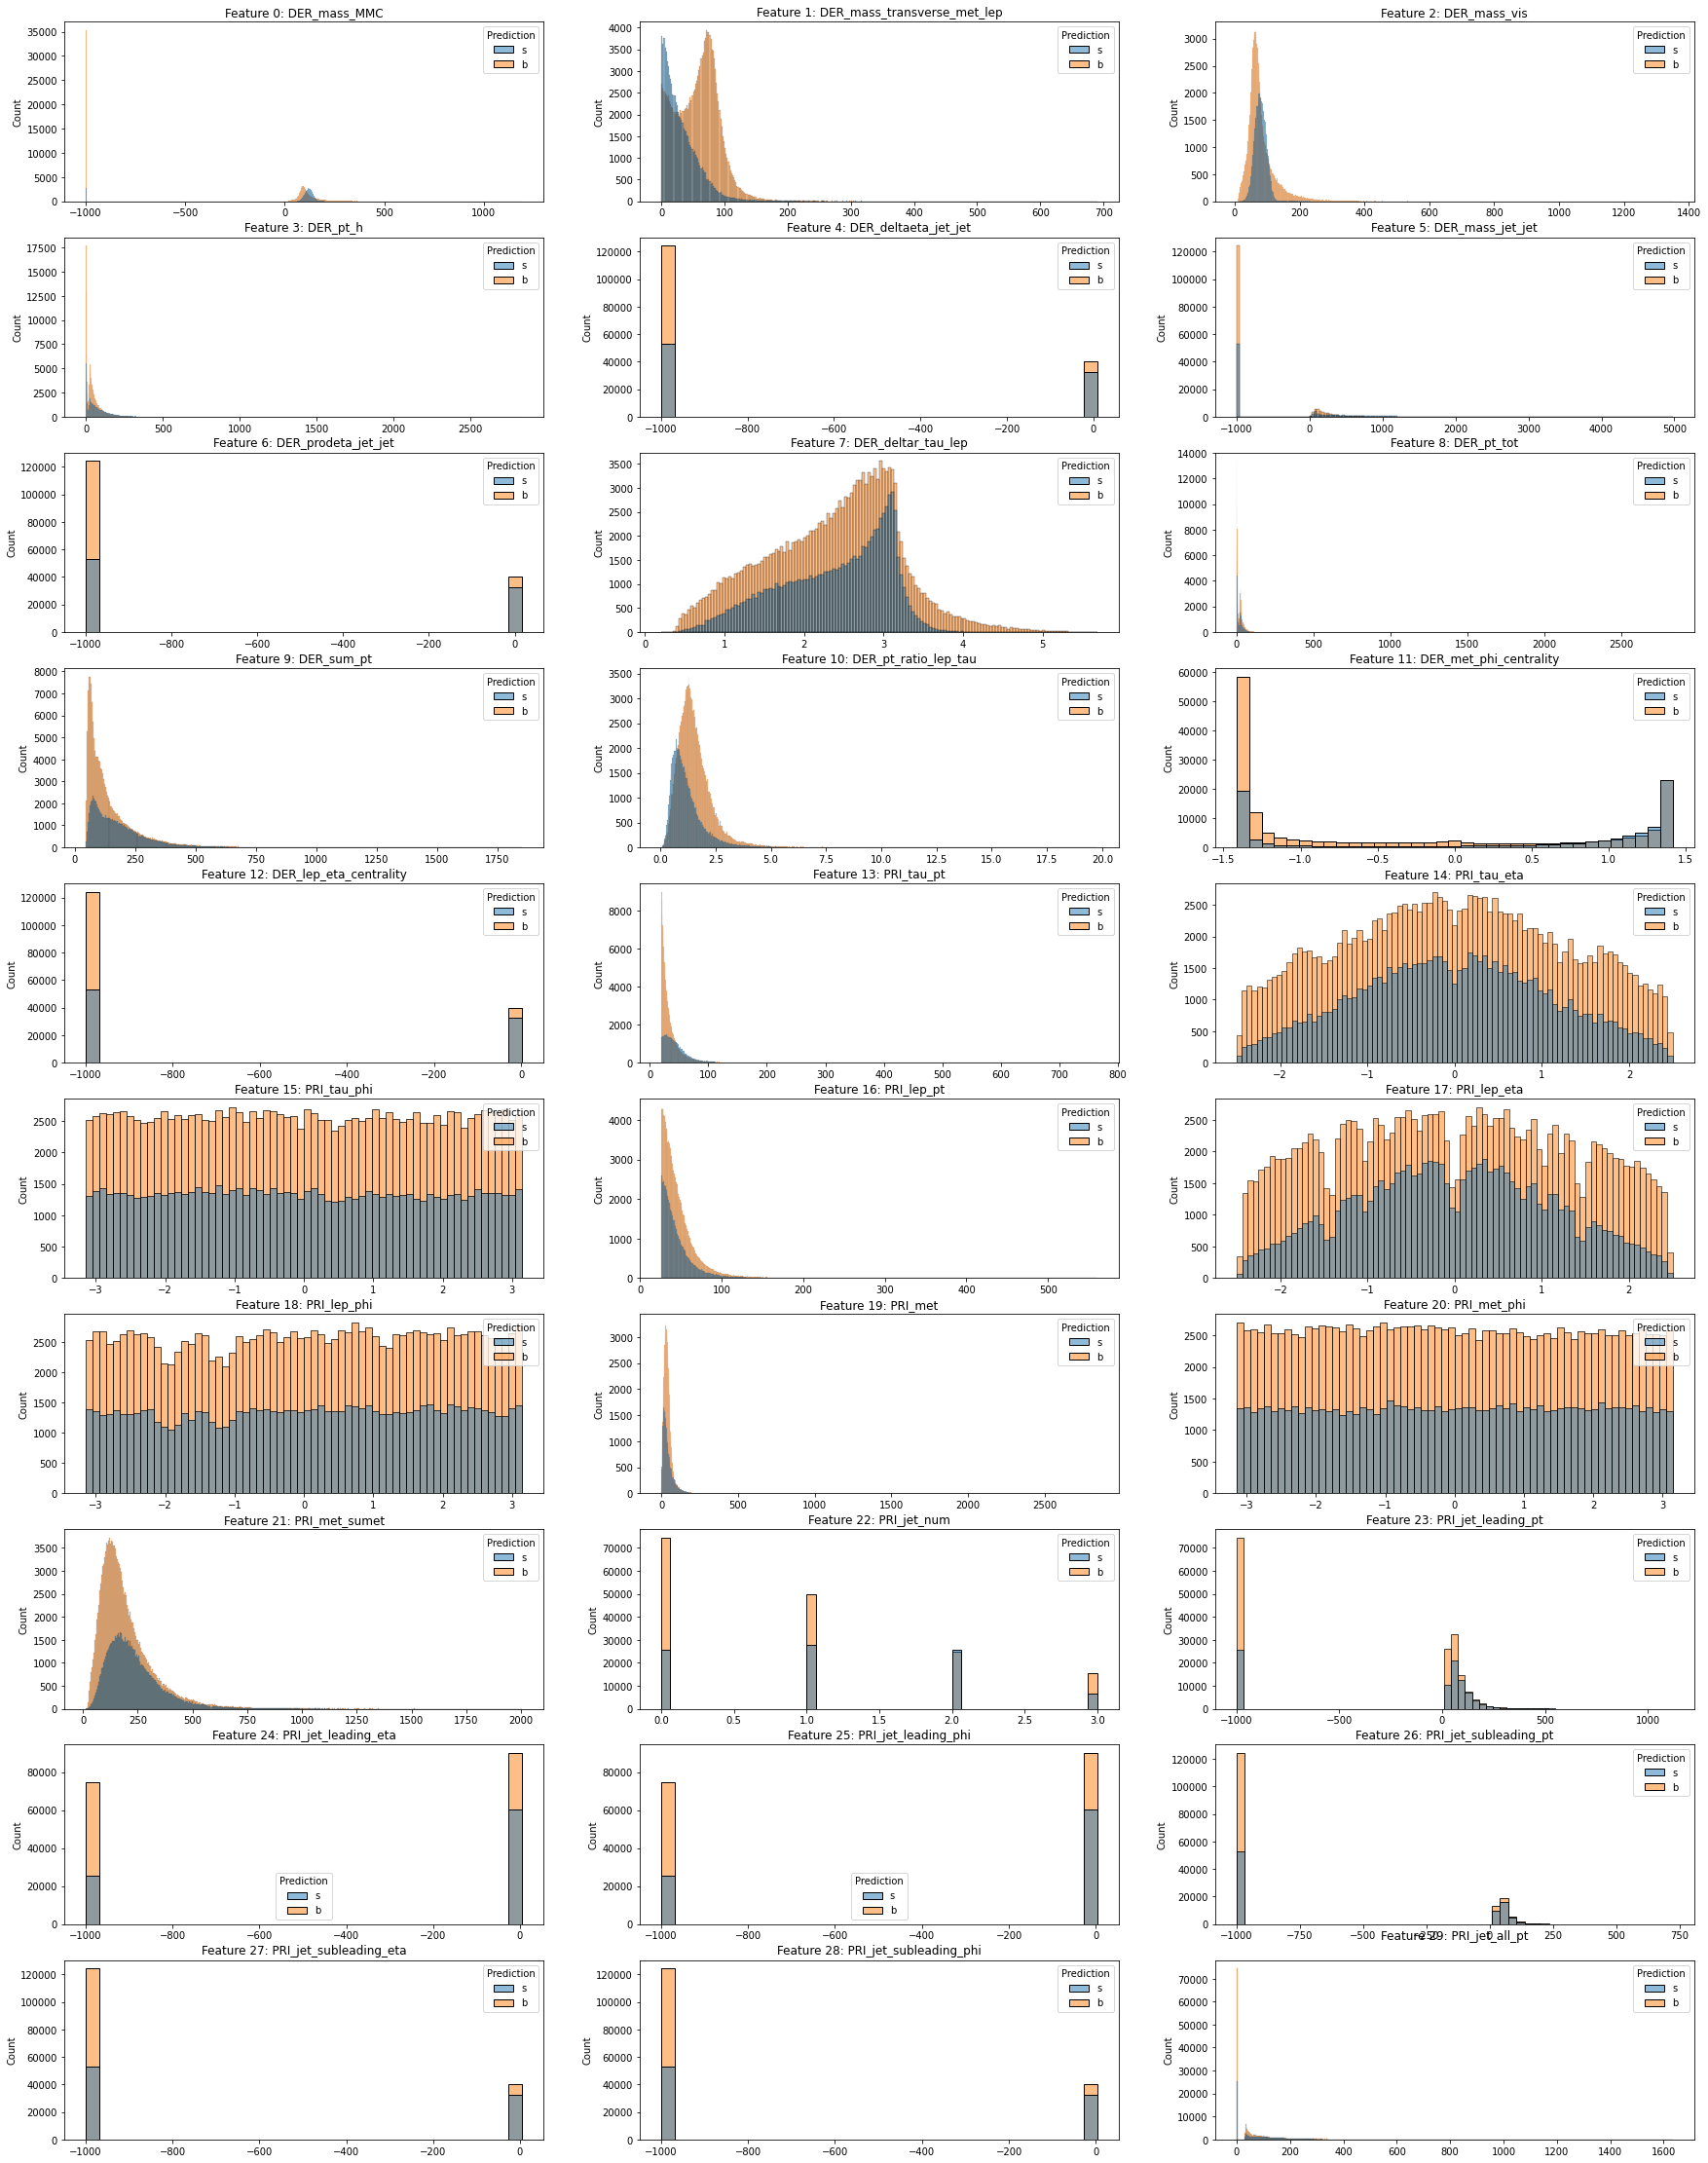

In [26]:
def seaborn_plot_features(df, hue):
    f, a = plt.subplots(10, 3, figsize=(30, 40))
    i=0
    for feature_name in df.columns[2:]:
        plt.subplot(10,3,i+1)
        plt.title("Feature {}: {}".format(i, labels[i]))
        sns.histplot(data=df, hue=hue, x=feature_name, multiple="layer").set_xlabel("")
        i+=1
seaborn_plot_features(df, "Prediction")

At first hand, most features seem to not be too heavily correlated with the label. (15, 17, 18, etc...)

We however notice, that bosons, lead to somewhat less invalid values (for instance with 26,27, 28), therefore it might be wise to keep this information ! 

Feature 1,2,7,9,10 or 24 however seem to really follow a different distribution based on the label

## III. Feature engineering

In [13]:
df_aug = df.copy()
df_aug["nan_count"] = [row.value_counts().get(-999.0, 0) for _, row in df_aug.iterrows()]

In [19]:
df_aug.head()

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,nan_count
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,7
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,8
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,10
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,10


Text(0.5, 1.0, 'Feature 30: nan_count')

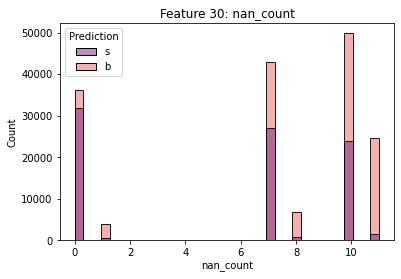

In [15]:
sns.histplot(data=df_aug, hue='Prediction', x="nan_count", palette="magma", multiple="layer").set_title("Feature {}: {}".format(30, "nan_count"))


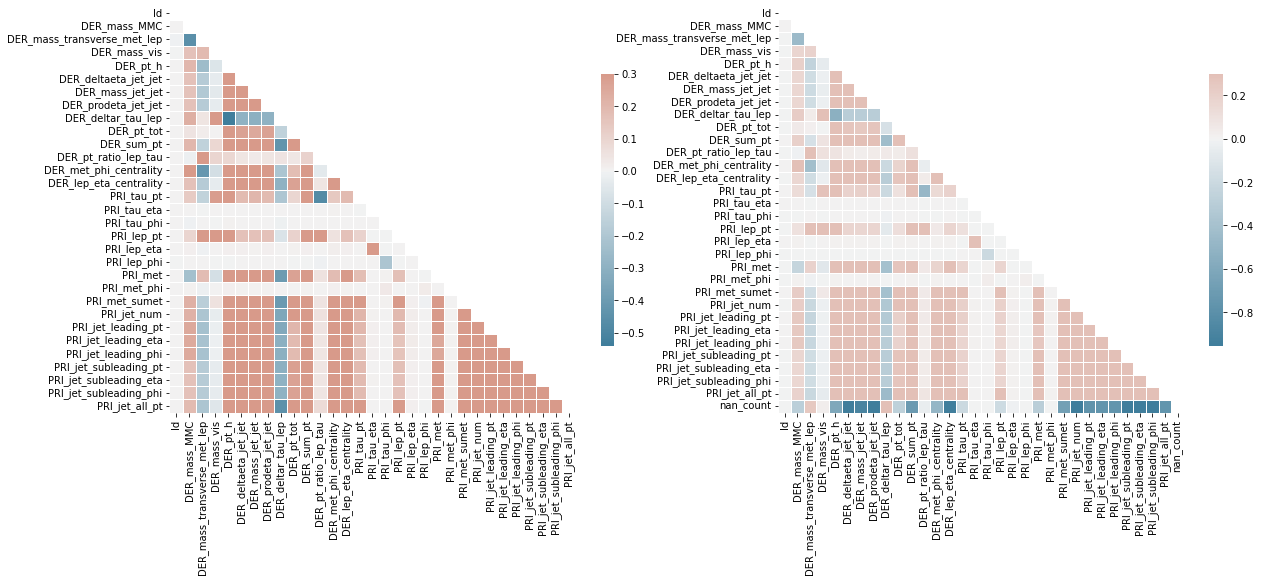

In [46]:
def plot_corr_matrix(df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.plot()

f, a = plt.subplots(1, 2, figsize=(20, 10))
plt.subplot(121)
plot_corr_matrix(df)
plt.subplot(122)
plot_corr_matrix(df_aug)


It seems that this derived feature overshadows a lot of the correlation ! 

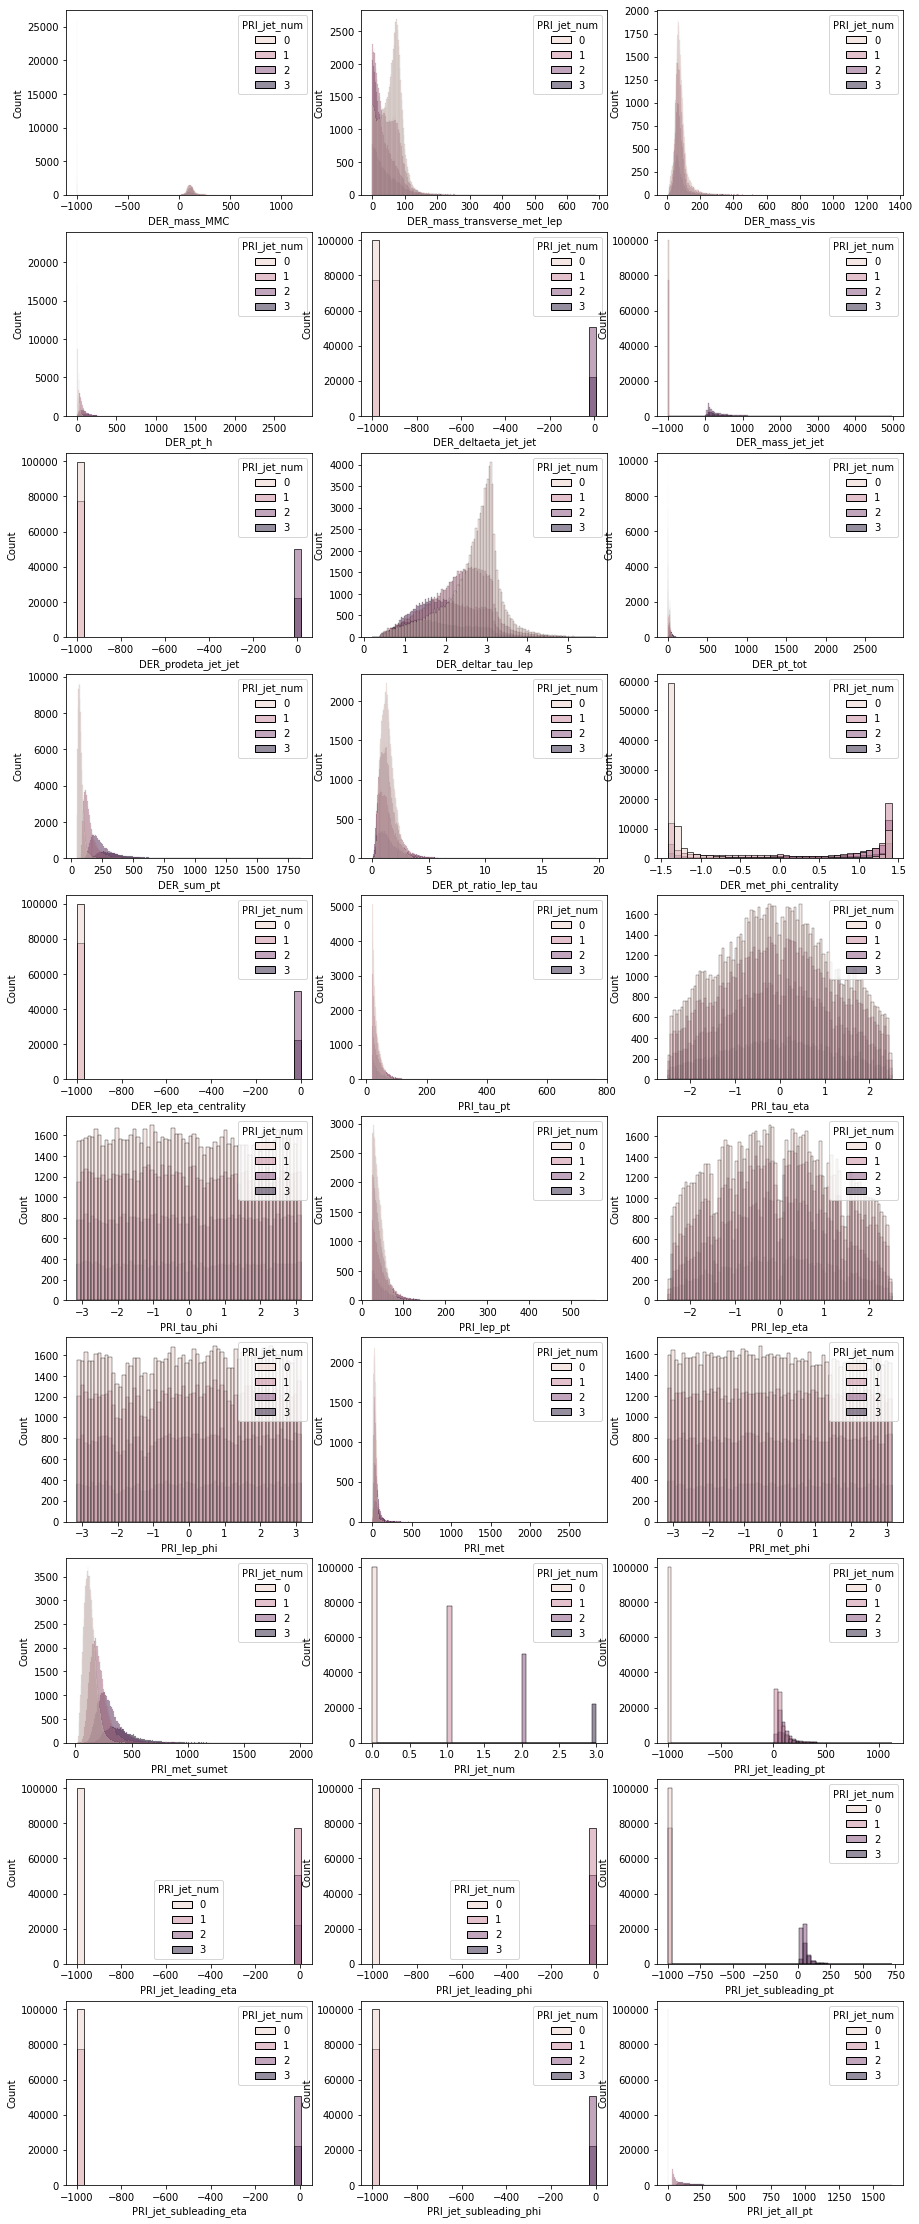

In [61]:
seaborn_plot_features(df, "PRI_jet_num")

Discriminating on those jet numbers seems to heavily alter some of the distributions. It would perhaps make sense to split the data according to this feature, and train different models for each

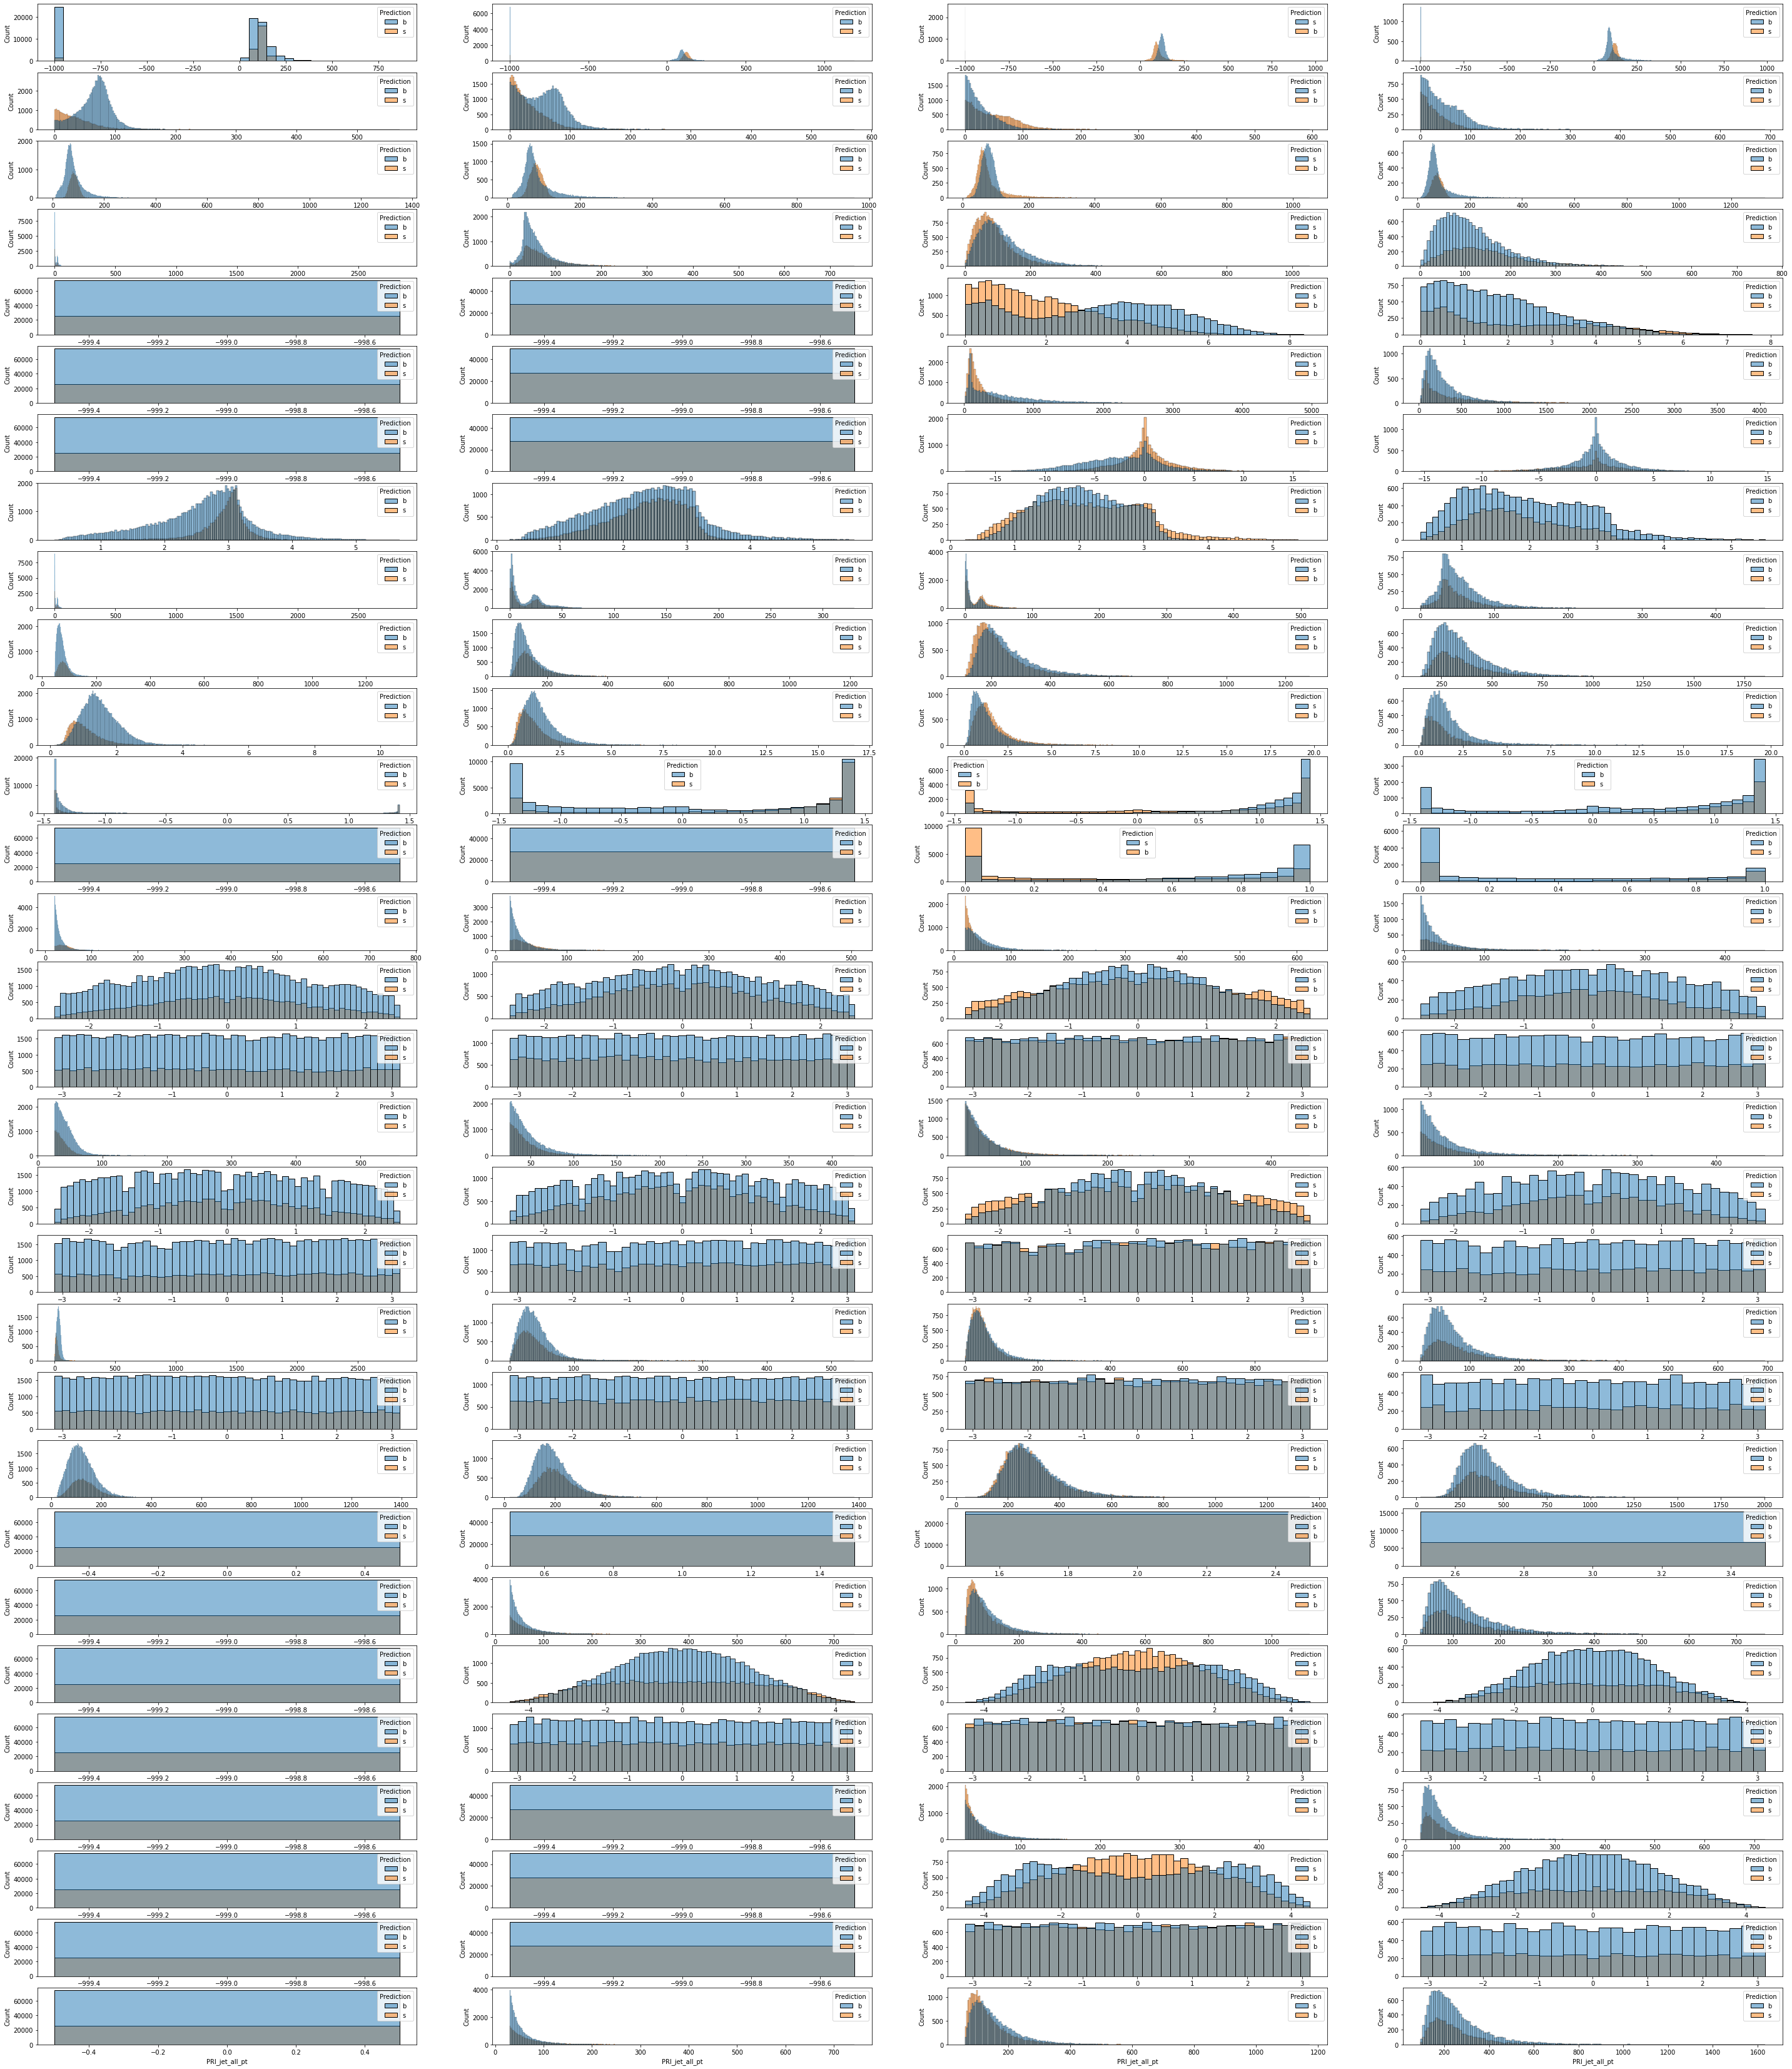

In [22]:
def seaborn_plot_features(df):
    i=0
    f, a = plt.subplots(30, 4, figsize=(50, 60))
    i=0
    for feature_name in df.columns[2:]:
        for j in range(4):
            sns.histplot(ax=a[i,j], data=df[df["PRI_jet_num"]==j],x=feature_name, hue="Prediction",multiple="layer")
        i+=1
seaborn_plot_features(df)

In [1]:
row_nan_pct = np.count_nonzero(tX == -999, axis=0) / len(tX)

NameError: name 'np' is not defined

In [ ]:
row_nan_pct 

array([0.152456, 0.      , 0.      , 0.      , 0.709828, 0.709828,
       0.709828, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.709828, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.399652,
       0.399652, 0.399652, 0.709828, 0.709828, 0.709828, 0.      ])

In [ ]:
np.count_nonzero(row_nan_pct == 0)

19

In [51]:
non_nan_cols = (row_nan_pct == 0)

In [52]:
non_nan_cols

array([False,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True])

In [53]:
tX_new = tX[:, non_nan_cols]

In [54]:
tX_new.shape

(250000, 19)

In [63]:
tX_new.shape

(250000, 19)

In [64]:
from implementations import build_poly
tX_poly = build_poly(tX_new, 7)

In [65]:
tX_poly.shape

(19, 250000, 8)

In [83]:
from implementations import ridge_regression_kfold
weights, lambda_, loss, accuracy, f1 = ridge_regression_kfold(y, tX_new)

In [86]:
print(f'{weights=}\n{lambda_=}\n{loss=}\n{accuracy=}\n{f1=}')

weights=array([-8.20161480e-03, -3.33148311e-03, -3.43187966e-04,  1.18378637e-01,
       -1.68390878e-03,  1.78322990e-03, -3.14669530e-01,  1.26590352e-01,
        1.43647534e-03, -8.59534906e-04, -1.28712503e-03,  1.10000176e-02,
        7.81830952e-04,  3.11060158e-04,  1.98643482e-03,  2.35543825e-04,
       -1.09092679e-03,  1.71299503e-02, -1.40219709e-03])
lambda_=0.0001
loss=0.8514766693980778
accuracy=0.724084
f1=0.6778866982685252


In [78]:
from implementations import predict
y_pred = predict(tX_new, weights)

In [79]:
y_pred

array([[-0.19484935],
       [-0.06108761],
       [-0.89854754],
       ...,
       [-0.29931265],
       [ 0.19327472],
       [-0.45989102]])

In [69]:
DATA_TEST_PATH = 'data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [70]:
tX_test.shape

(568238, 30)

In [71]:
tX_test_new = tX_test[:, non_nan_cols]

In [72]:
tX_test_new.shape

(568238, 19)

In [73]:
from datetime import datetime
method = 'ridge_regression_cv'
time = datetime.now().strftime('%Y%m%dH%H%M%S')
OUTPUT_PATH = f'submissions/submission_{method}_{time}' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test_new)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)